In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.nn.modules import loss

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict

import time
import requests
from pathlib import Path
import zipfile
from PIL import Image
import os

In [ ]:
# Create directory for image training dataset
data_dir = Path('/tmp/isic_2016_data')
data_dir.mkdir(exist_ok=True)

# Download images of ISIC dataset
dataset_url = "https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part3_Training_Data.zip"
archive_path = data_dir / "ISIC_2016_Training_Input.zip"

# Download if not exists
if not archive_path.exists():
    print("Downloading ISIC dataset training images...")
    response = requests.get(dataset_url, stream=True)
    with open(archive_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Extract
    with zipfile.ZipFile(archive_path, 'r') as zip_file:
        zip_file.extractall(data_dir)

    print("Dataset extracted to:", data_dir)

Dataset extracted to: /tmp/isic_2016_data


In [ ]:
# Create directory for labels training dataset
data_dir = Path('/tmp/isic_2016_data')
data_dir.mkdir(exist_ok=True)

# Download labels of ISIC dataset
dataset_url = "https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv"
archive_path = data_dir / "ISIC_2016_Training_GroundTruth.csv"

# Download if not exists
if not archive_path.exists():
    print("Downloading ISIC dataset training labels...")
    response = requests.get(dataset_url, stream=True)
    with open(archive_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print("Dataset downloaded to:", data_dir)

Dataset downloaded to: /tmp/isic_2016_data


In [ ]:
# Create directory for image testing dataset
data_dir = Path('/tmp/isic_2016_data')
data_dir.mkdir(exist_ok=True)

# Download images of ISIC dataset
dataset_url = "https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part3_Test_Data.zip"
archive_path = data_dir / "ISIC_2016_Testing_Input.zip"

# Download if not exists
if not archive_path.exists():
    print("Downloading ISIC dataset testing images...")
    response = requests.get(dataset_url, stream=True)
    with open(archive_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    # Extract
    with zipfile.ZipFile(archive_path, 'r') as zip_file:
        zip_file.extractall(data_dir)

    print("Dataset extracted to:", data_dir)

Dataset extracted to: /tmp/isic_2016_data


In [ ]:
# Create directory for labels training dataset
data_dir = Path('/tmp/isic_2016_data')
data_dir.mkdir(exist_ok=True)

# Download labels of ISIC dataset
dataset_url = "https://isic-archive.s3.amazonaws.com/challenges/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv"
archive_path = data_dir / "ISIC_2016_Testing_GroundTruth.csv"

# Download if not exists
if not archive_path.exists():
    print("Downloading ISIC dataset training labels...")
    response = requests.get(dataset_url, stream=True)
    with open(archive_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print("Dataset downloaded to:", data_dir)

Dataset downloaded to: /tmp/isic_2016_data


In [ ]:
class ISICBinaryDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_ext = '.jpg'

        self.df = pd.read_csv(csv_file, header=None, sep=',')
        print(f"CSV loaded: {self.df.shape} | Columns: {len(self.df.columns)}")

        if len(self.df.columns) != 2:
            raise ValueError(f"Expected 2 columns, got {len(self.df.columns)}")

        self.valid_indices = []
        for idx in range(len(self.df)):
            img_id = str(self.df.iloc[idx, 0]).strip()
            img_path = os.path.join(self.image_dir, img_id + self.image_ext)
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
            else:
                print(f"Missing: {img_path}")

        print(f"Loaded {len(self.valid_indices)} valid images")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]

        img_id = str(self.df.iloc[actual_idx, 0]).strip()

        # Training set uses "benign" and "malignant" while testing set uses 0 and 1. Dealing with both cases
        label_raw = str(self.df.iloc[actual_idx, 1]).strip()
        if label_raw.lower() in ['benign', '0', '0.0']:
            label = 0
        elif label_raw.lower() in ['malignant', '1', '1.0']:
            label = 1
        else:
            raise ValueError(f"Unknown label: {label_raw}")

        label = torch.tensor(label, dtype=torch.long)

        img_name = img_id + self.image_ext
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# To check where the images are
'''import os
base_dir = '/tmp/isic_2016_data/'

print("=== DIRECTORY STRUCTURE ===")
for root, dirs, files in os.walk(base_dir):
    if files:
        print(f"{root}: {len(files)} files")
        print("  Sample:", os.listdir(root)[:3])
        print()

print("=== FIRST 10 FILES IN TRAINING DIR ===")
train_dir = '/tmp/isic_2016_data/ISIC_2016_Train_Data/'
if os.path.exists(train_dir):
    files = os.listdir(train_dir)[:10]
    print(files)
else:
    print("TRAINING DIR DOES NOT EXIST!")

print("=== LOOKING FOR ANY JPGs ===")
jpg_count = 0
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith('.jpg'):
            jpg_count += 1
            if jpg_count <= 3:
                print(f"Found: {os.path.join(root, f)}")
print(f"TOTAL JPGs: {jpg_count}")'''

'import os\nbase_dir = \'/tmp/isic_2016_data/\'\n\nprint("=== DIRECTORY STRUCTURE ===")\nfor root, dirs, files in os.walk(base_dir):\n    if files:\n        print(f"{root}: {len(files)} files")\n        print("  Sample:", os.listdir(root)[:3])\n        print()\n\nprint("=== FIRST 10 FILES IN TRAINING DIR ===")\ntrain_dir = \'/tmp/isic_2016_data/ISIC_2016_Train_Data/\'\nif os.path.exists(train_dir):\n    files = os.listdir(train_dir)[:10]\n    print(files)\nelse:\n    print("TRAINING DIR DOES NOT EXIST!")\n\nprint("=== LOOKING FOR ANY JPGs ===")\njpg_count = 0\nfor root, dirs, files in os.walk(base_dir):\n    for f in files:\n        if f.endswith(\'.jpg\'):\n            jpg_count += 1\n            if jpg_count <= 3:\n                print(f"Found: {os.path.join(root, f)}")\nprint(f"TOTAL JPGs: {jpg_count}")'

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet standard
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # ImageNet stats
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

train_dataset = ISICBinaryDataset(
    image_dir='/tmp/isic_2016_data/ISBI2016_ISIC_Part3_Training_Data',
    csv_file='/tmp/isic_2016_data/ISIC_2016_Training_GroundTruth.csv',
    transform=train_transform
)

test_dataset = ISICBinaryDataset(
    image_dir='/tmp/isic_2016_data/ISBI2016_ISIC_Part3_Test_Data',
    csv_file='/tmp/isic_2016_data/ISIC_2016_Testing_GroundTruth.csv',
    transform=test_transform
)

print(f"Train: {len(train_dataset)} images")
print(f"Test:  {len(test_dataset)} images")

CSV loaded: (900, 2) | Columns: 2
Loaded 900 valid images
CSV loaded: (379, 2) | Columns: 2
Loaded 379 valid images
Train: 900 images
Test:  379 images


In [ ]:
def print_dataset_distribution(dataset, name):
    """Print unique values and distribution for dataset"""
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]  # Get label from dataset
        labels.append(label.item())

    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n=== {name} DISTRIBUTION ===")
    print(f"Total samples: {len(labels)}")
    for u, c in zip(unique, counts):
        percentage = c / len(labels) * 100
        print(f"  Class {u}: {c} samples ({percentage:.1f}%)")

# Print distributions for both datasets
print_dataset_distribution(train_dataset, "TRAINING SET")
print_dataset_distribution(test_dataset, "TESTING SET")


=== TRAINING SET DISTRIBUTION ===
Total samples: 900
  Class 0: 727 samples (80.8%)
  Class 1: 173 samples (19.2%)

=== TESTING SET DISTRIBUTION ===
Total samples: 379
  Class 0: 304 samples (80.2%)
  Class 1: 75 samples (19.8%)


In [ ]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

In [ ]:
# Defining Model
torch.manual_seed(42)
model = models.resnet18(weights='IMAGENET1K_V1') # ResNet 18
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Malignant or Benign

# Enable Finetuning
for param in model.parameters():
    param.requires_grad = False # Freeze entire model
for param in model.fc.parameters():
    param.requires_grad = True  # Unfreeze final layer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


In [ ]:
# Defining error function
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        focal = self.alpha * (1-pt)**self.gamma * ce
        return focal.mean()

criterion = FocalLoss(alpha=0.25, gamma=2.0)
# Defining optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01) # Only optimize unfrozen parameters

In [ ]:
start = time.time() # Defining start time

# Keeping track of relevant variables
epochs = 8
train_losses = [] # List of losses after training/testing in each epoch
test_losses = []
train_correct = [] # No. of correct values after training/testing in each epoch
test_correct = []

for i in range(epochs):
  trn_corr = 0 # No. of correct values in the epoch
  tst_corr = 0

  # Training
  model.train() # Training mode
  train_loss = 0
  num_train_batches = 0

  for b, (X_train, y_train) in enumerate(train_loader): # b = batch
    b+=1
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_pred = model(X_train) # Predict
    loss = criterion(y_pred, y_train) # Calculate loss

    train_loss += loss.item() # Adding losses
    num_train_batches += 1

    predicted = y_pred.detach().argmax(dim=1) # predicted value
    batch_corr = (predicted == y_train).sum().item() # No. of correct values in batch
    trn_corr += batch_corr

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out loss at intervals
    if b%6 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item():.4f}')

  # Update list of losses and correct after training
  train_losses.append(train_loss/num_train_batches) # Average error of batch
  train_correct.append(trn_corr)

  # Testing
  model.eval() # Testing mode
  test_loss = 0
  num_test_batches = 0

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_val = model(X_test)

      test_loss += criterion(y_val, y_test).item() # Adding losses
      num_test_batches += 1

      predicted = y_val.detach().argmax(dim=1)
      tst_corr += (predicted == y_test).sum().item()

  # Update list of losses and correct after testing
  test_losses.append(test_loss/num_test_batches) # Avg loss per batch
  test_correct.append(tst_corr)

end = time.time() # Defining end time
print(f'Total time: {(end-start)/60} minutes')

torch.save(model.state_dict(), 'ISIC_2016_ResNet18.pth')

epoch: 0  batch: 6  loss: 0.6671
epoch: 0  batch: 12  loss: 0.4045
epoch: 0  batch: 18  loss: 0.0507
epoch: 0  batch: 24  loss: 0.0286
epoch: 1  batch: 6  loss: 0.0206
epoch: 1  batch: 12  loss: 0.0538
epoch: 1  batch: 18  loss: 0.0527
epoch: 1  batch: 24  loss: 0.0292
epoch: 2  batch: 6  loss: 0.0483
epoch: 2  batch: 12  loss: 0.0603
epoch: 2  batch: 18  loss: 0.0244
epoch: 2  batch: 24  loss: 0.0120
epoch: 3  batch: 6  loss: 0.0857
epoch: 3  batch: 12  loss: 0.0635
epoch: 3  batch: 18  loss: 0.0342
epoch: 3  batch: 24  loss: 0.0378
epoch: 4  batch: 6  loss: 0.0381
epoch: 4  batch: 12  loss: 0.0127
epoch: 4  batch: 18  loss: 0.0094
epoch: 4  batch: 24  loss: 0.0291
epoch: 5  batch: 6  loss: 0.0295
epoch: 5  batch: 12  loss: 0.0534
epoch: 5  batch: 18  loss: 0.0102
epoch: 5  batch: 24  loss: 0.0291
epoch: 6  batch: 6  loss: 0.0285
epoch: 6  batch: 12  loss: 0.0500
epoch: 6  batch: 18  loss: 0.0424
epoch: 6  batch: 24  loss: 0.0352
epoch: 7  batch: 6  loss: 0.0525
epoch: 7  batch: 12  l

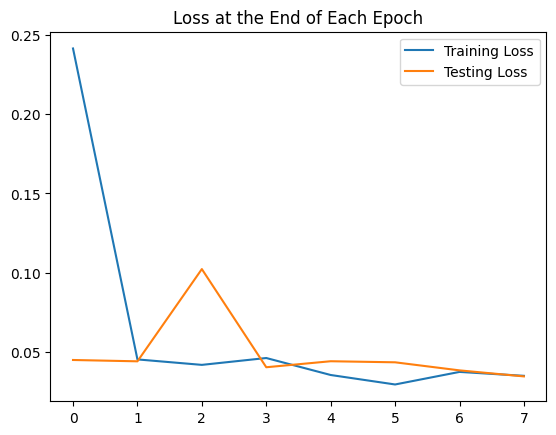

In [ ]:
# Graphing Loss vs Epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the End of Each Epoch')
plt.legend()

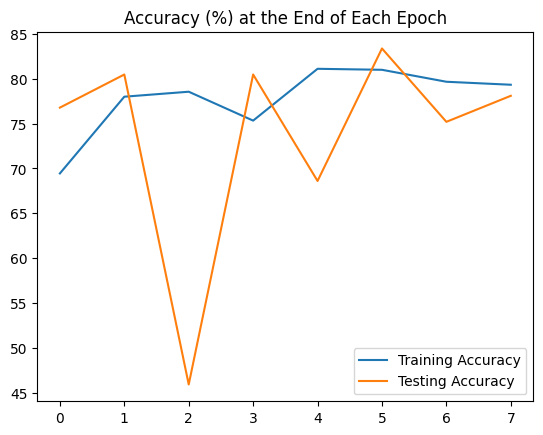

In [ ]:
# Graphing Accuracy (%) vs Epoch
plt.plot([t/len(train_dataset)*100 for t in train_correct], label='Training Accuracy')
plt.plot([t/len(test_dataset)*100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy (%) at the End of Each Epoch')
plt.legend()

In [ ]:
# Evaluation Function
def evaluate_model(model, test_loader, device, num_classes=2):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_confidences = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)

            # Get probabilities (softmax)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_confidences.extend(probs.max(dim=1)[0].cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return all_preds, all_labels, all_probs, all_confidences


# Run Evaluation
print("Computing evaluation metrics...")
preds, labels, probs, confidences = evaluate_model(model, test_loader, device)

Computing evaluation metrics...


In [ ]:
# Basic Metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='binary', pos_label=1)
recall = recall_score(labels, preds, average='binary', pos_label=1)
f1 = f1_score(labels, preds, average='binary', pos_label=1)
auc = roc_auc_score(label_binarize(labels, classes=[0,1]), probs[:,1])

print(f"\n Final Metrics:")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


 Final Metrics:
Accuracy:  0.7810 (78.1%)
Precision: 0.4444
Recall:    0.4267
F1-Score:  0.4354
ROC-AUC:   0.7601


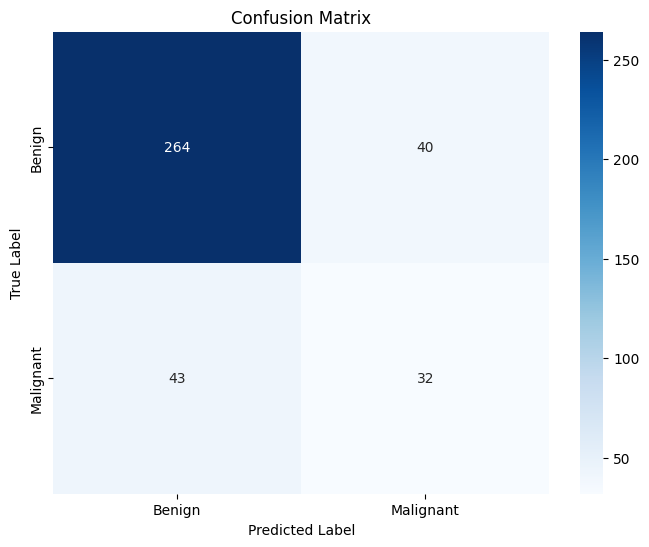

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

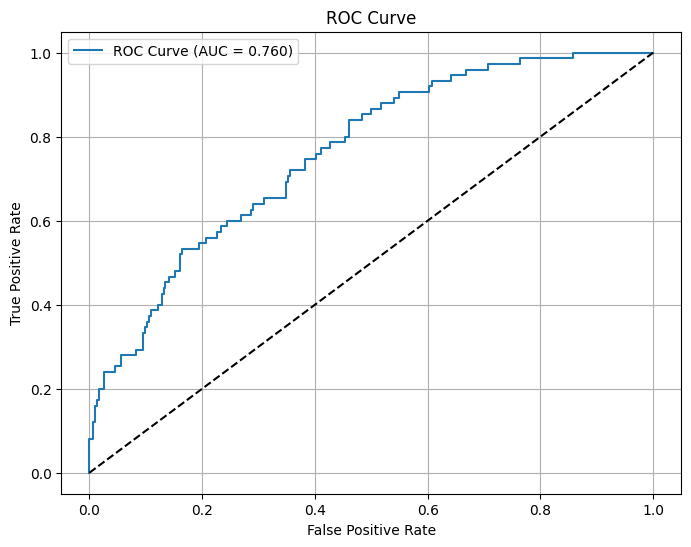

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

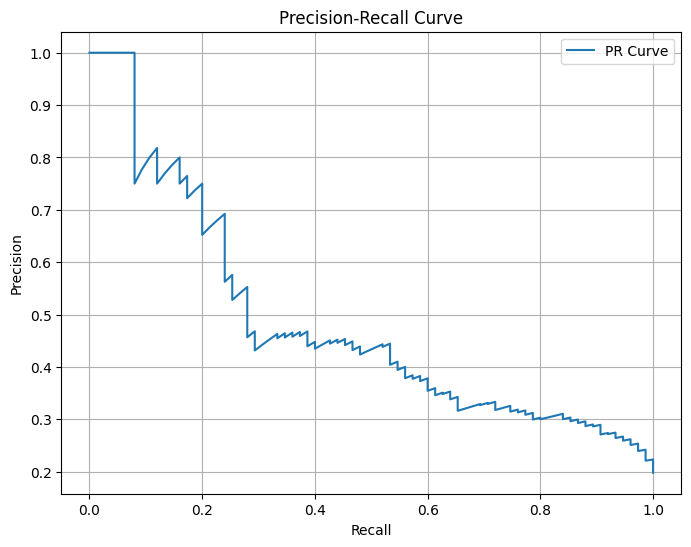

In [ ]:
# Precisio-Recall Curve (PR Curve)
precision_vals, recall_vals, _ = precision_recall_curve(labels, probs[:,1])
plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Top 10 Best vs Worst Predictions
# Sort by confidence
results = list(zip(labels, preds, confidences, probs[:,1]))
results.sort(key=lambda x: x[2], reverse=True)  # Highest confidence first

print("\n Top 10 Best Predictions:")
for i in range(10):
    label, pred, conf, prob = results[i]
    print(f"{i+1}. True:{label} Pred:{pred} Conf:{conf:.3f} Prob:{prob:.3f}")

print("\n Top 10 Worst Predictions:")
for i in range(10):
    label, pred, conf, prob = results[-1-i]
    print(f"{i+1}. True:{label} Pred:{pred} Conf:{conf:.3f} Prob:{prob:.3f}")


 Top 10 Best Predictions:
1. True:0 Pred:0 Conf:0.987 Prob:0.013
2. True:0 Pred:0 Conf:0.985 Prob:0.015
3. True:0 Pred:0 Conf:0.978 Prob:0.022
4. True:0 Pred:0 Conf:0.970 Prob:0.030
5. True:0 Pred:0 Conf:0.968 Prob:0.032
6. True:0 Pred:0 Conf:0.964 Prob:0.036
7. True:0 Pred:0 Conf:0.963 Prob:0.037
8. True:0 Pred:0 Conf:0.960 Prob:0.040
9. True:0 Pred:0 Conf:0.959 Prob:0.041
10. True:0 Pred:0 Conf:0.958 Prob:0.042

 Top 10 Worst Predictions:
1. True:1 Pred:0 Conf:0.501 Prob:0.499
2. True:0 Pred:0 Conf:0.502 Prob:0.498
3. True:1 Pred:0 Conf:0.504 Prob:0.496
4. True:0 Pred:0 Conf:0.506 Prob:0.494
5. True:0 Pred:0 Conf:0.507 Prob:0.493
6. True:0 Pred:1 Conf:0.511 Prob:0.511
7. True:1 Pred:1 Conf:0.511 Prob:0.511
8. True:1 Pred:0 Conf:0.513 Prob:0.487
9. True:1 Pred:1 Conf:0.513 Prob:0.513
10. True:0 Pred:1 Conf:0.513 Prob:0.513


In [ ]:
# Hooks to extract ResNet layer4 features
feature_maps = []
def get_features(name):
    def hook(model, input, output):
        feature_maps.append(output.detach().cpu()) # Remove gradient and move map to CPU
    return hook

# Take features from hook at layer 4 (final convo layer of ResNet-18)
# Note layer here refers to block (not individual convolution)
hook = model.layer4.register_forward_hook(get_features(name='layer4'))

# Run test images through model
model.eval()
with torch.no_grad():
    for i, (img, label) in enumerate(test_loader):
        img = img.to(device)
        _ = model(img)  # Triggers hook and ignore output
        break  # Just first batch

hook.remove()
features = feature_maps[0]  # Extract features of first batch. [batch_size, 512, 7, 7]

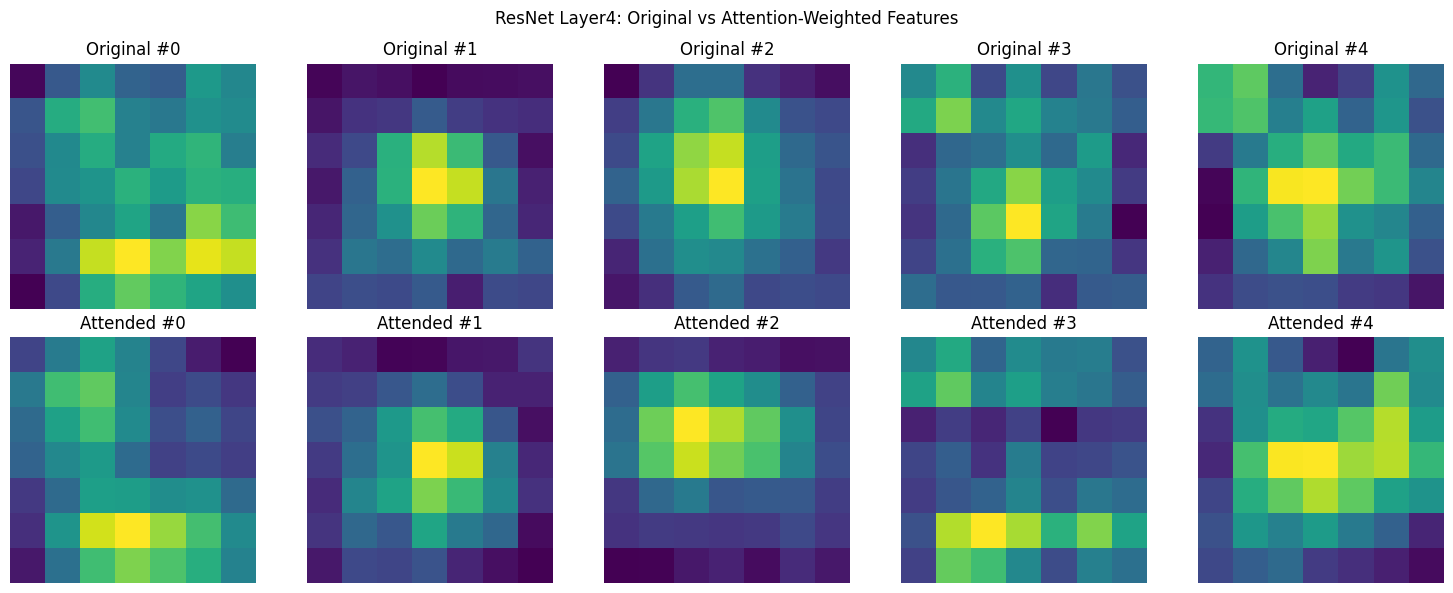

In [ ]:
# Simple Attention
def simple_attention(features):
    gap = features.mean(dim=[2,3])  # Global Average Pooling. Each channel has 1 score per image which indicates its importance. [batch_size, 512]
    weights = torch.softmax(gap, dim=1).unsqueeze(-1).unsqueeze(-1)  # Convert scores to probability distribution. [batch_size, 512, 1, 1]
    attended = features * weights  # Apply attention. More important channels have higher weightage. [batch_size, 512, 7, 7]
    return attended, weights

attended, attn_weights = simple_attention(features)

# Original vs Attended feature maps
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):  # 5 sample images
    # Finding max activation
    orig_max = features[i].max(dim=0)[0]  # [7,7]
    attended_max = attended[i].max(dim=0)[0]  # [7,7]

    axes[0,i].imshow(orig_max, cmap='viridis')
    axes[0,i].set_title(f'Original #{i}')
    axes[0,i].axis('off')

    axes[1,i].imshow(attended_max, cmap='viridis')
    axes[1,i].set_title(f'Attended #{i}')
    axes[1,i].axis('off')

plt.suptitle('ResNet Layer4: Original vs Attention-Weighted Features')
plt.tight_layout()
plt.show()